# Практическое задание 1
## Мария Такташева
# Задача 1

В файле edges.txt находится фрагмент (неориентированного) графа социальной сети, заданный списком рёбер: каждая строка представляет собой одно ребро в виде пары записанных через пробел идентификаторов смежных вершин.
Найдите кластерные коэффициенты (глобальный и средний локальный) этого графа и его диа- метр. (1 балл)
Постройте график распределения степеней вершин графа и график ассортативности dnn(d). Яв- ляется ли сеть ассортативной или дисассортативной? (3 балла)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np

G = nx.read_edgelist('data/edges.txt')

In [3]:
print(f'Глобальный кластерный коеффициент: {nx.transitivity(G):.3}')
print(f'Средний локальный кластерный коеффициент: {nx.average_clustering(G):.3}')

Глобальный кластерный коеффициент: 0.449
Средний локальный кластерный коеффициент: 0.544


### Диаметр

А вот диаметр посчитать не можем, потому что граф имеет 2 компоненты связности, посчитаем диаметр для большей из них

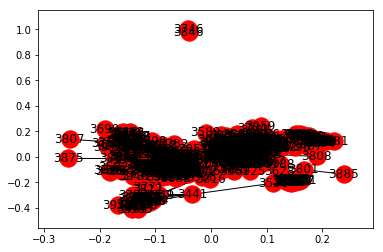

In [4]:
nx.draw_networkx(G)

In [5]:
G1 = G.copy()
G1.remove_node('3846')
G1.remove_node('3746')
nx.number_connected_components(G1)

1

In [6]:
print(f'Диаметр: {nx.diameter(G1)}')

Диаметр: 9


### График распределения степеней вершин

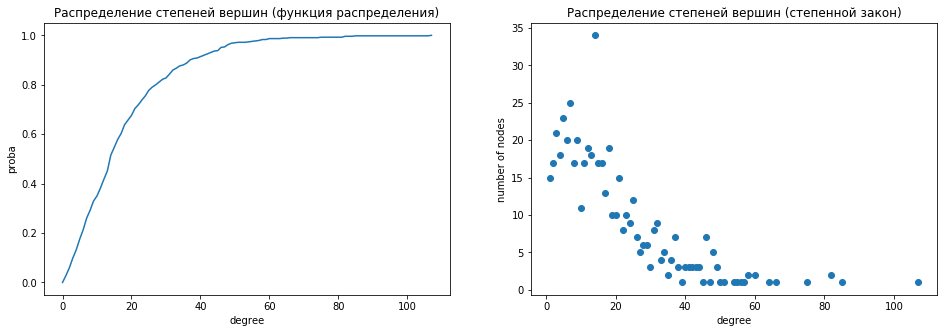

In [7]:
from collections import Counter

cdf = []
degree_list = nx.degree_histogram(G)
number_of_nodes = G.number_of_nodes()
for d, number in enumerate(degree_list):
    value = np.sum(degree_list[:d + 1]) / number_of_nodes 
    cdf.append(value)

degrees = dict(G.degree())
degrees_count = Counter(degrees.values())

plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.title('Распределение степеней вершин (функция распределения)')
plt.plot(cdf)
plt.xlabel('degree')
plt.ylabel('proba');

plt.subplot(1,2,2)
plt.title('Распределение степеней вершин (степенной закон)')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.scatter(*zip(*sorted(degrees_count.items())))
plt.show()

### График ассортативности

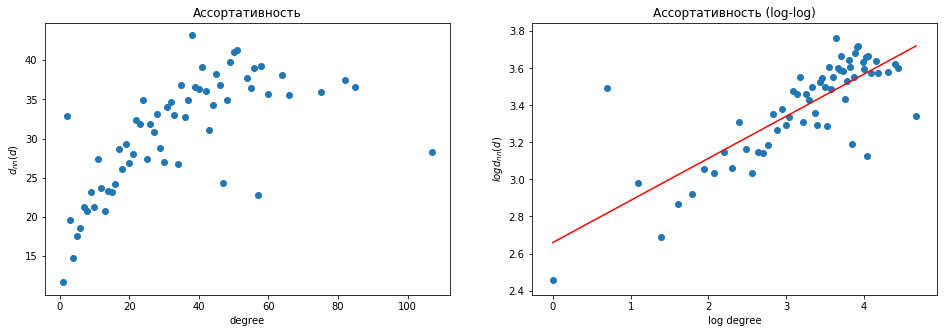

In [8]:
knn = nx.k_nearest_neighbors(G)
x, y = zip(*sorted(knn.items()))
logx, logy = np.log(x), np.log(y)
xspace = np.linspace(np.min(logx), np.max(logx))
fit = np.polyfit(logx, logy, deg=1)

plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.title('Ассортативность')
plt.xlabel('degree')
plt.ylabel('$d_{nn}(d)$')
plt.scatter(x, y)

plt.subplot(1,2,2)
plt.title('Ассортативность (log-log)')
plt.xlabel('log degree')
plt.ylabel('$log d_{nn}(d)$')
plt.plot(xspace, fit[0] * xspace + fit[1], color='red')
plt.scatter(logx, logy)
plt.show()

Сеть ассортативна, поскольку $\delta$ > 0

In [9]:
print(f'delta = {fit[0]:.2}')

delta = 0.23


# Задача 2

Выберите ЖЖ какого-нибудь блогера. По адресу http://www.livejournal.com/misc/fdata.bml?user=username
можно скачать список пользователей, которые являются друзьями или находятся в друзьях у поль- зователя username. Для каждого из друзей выбранного блогера также скачайте список его друзей, в итоге получится ориентированный граф друзей пользователя. Найдите локальный кластерный коэффициент выбранного блогера в графе социальной сети. Визуализируйте полученный фрагмент графа так, чтобы размер вершин и подписей к ним были пропорциональны PageRank’у. Вершины должны быть подписаны именами соответствующих пользователей. Проинтерпретируйте резуль- тат.(4 балла)

In [10]:
import requests
import time
from tqdm import tqdm

def friendlist_to_edges(username):
    page = requests.get(f'http://www.livejournal.com/misc/fdata.bml?user={username}')
    for line in page.iter_lines(decode_unicode=True):
        if line.startswith('>'):
            lj_graph.add_edge(username, line[2:])
        elif line.startswith('<'):
            lj_graph.add_edge(line[2:], username)

In [12]:
lj_graph = nx.DiGraph()

baseusername = 'quadrapedia'
friendlist_to_edges(baseusername)
nodes = list(lj_graph.nodes)
nodes.remove(baseusername)

# скачаем граф выбранного пользователя

for username in tqdm(nodes):
    time.sleep(0.5)
    friendlist_to_edges(username)

nx.write_edgelist(lj_graph, 'data/lj_graph.csv')

100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Локальный кластерный коэффициент

In [43]:
def local_clustering(G, node):
    c = 0
    for i in G.neighbors(node):
        for j in G.neighbors(node):
            if G.has_edge(i, j):
                c += 1
    n = len(list(G.neighbors(node)))
    return c / (n * (n - 1))

In [44]:
print(f'Локальный кластерный коэффициент: {local_clustering(lj_graph, baseusername):.3}')

Локальный кластерный коэффициент: 0.327


Визуализирую в Gephi. 

Поскольку я взяла блог своей однокурсницы, читающей известных экономистов, основные хабы в графе — экономисты с наибольшим количеством читателей. Выделяются akteon, ksonin и macroevolution — их блоги читают чаще всего, поэтому и пейджранк большой.

Отдельно выделяется пользователь eregwen — это популярный блогер, пишуший не про экономику, поэтому пользователь сильно отдален от экономистов.

Кроме того, заметно, что у крупных пользователей есть общие друзья и подписчики, а также большие группы несвязанных подписчиков

Сеть вокруг выбранного пользователя достаточно плотная — есть почти треть ребер между соседями. Это может быть из-за того, что выбранный пользователь находится в некоторой группе по интересами — читает блоги по экономике


![lj_graph](data/lj_graph.png)

# Задача 3
Будем использовать следующее определение второй степени вершины t

$$ d_2(t) = |\{\{i,j\} : i \ne t,j \ne t, \{i,t\} ∈ E(G), \{i,j\} ∈ E(G)\}| $$ 

Т. е. вторая степень вершины t — это количество ребер, которые инцидентны соседям t, кроме тех, концом которых является t. При этом если в вершине i, соединенной с t, есть петля, то она дает вклад 2 во вторую степень.

Найдите число вершин второй степени 4 в неориентированном графе с петлями, без кратных ребер, заданном в файле graph.txt. В каждой строке через символ табуляции задана пара вершин, соединенных ребром. (3 балла)

Найдите в этом же графе число треугольников, то есть число таких троек попарно различных вершин (a, b, c), для которых в графе существуют ребра (a, b), (a, c), и (b, c). (2 балла)

In [13]:
G = nx.read_edgelist('data/graph.txt')

In [14]:
def second_deg(G, node):
    deg2 = 0
    for i in G.neighbors(t):       
        if i == t:
            continue
        for j in G.neighbors(i):
            if j == i:
                deg2 += 2
            elif j == t:
                continue
            else:
                deg2 += 1
    return deg2

In [15]:
count = 0
for t in G.nodes():
    if second_deg(G, t) == 4:
        count += 1
                    
print('Число вершин deg2 = 4:', count)

Число вершин deg2 = 4: 833


In [16]:
print('Число треугольников:', np.sum(list(nx.triangles(G).values())) / 3)

Число треугольников: 0.0
